In [18]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import numpy as np
from scipy.fft import rfft, irfft
from scipy.signal import hann

def buffer(X: np.ndarray, n: int, p: int,zeros: int) -> np.ndarray:
    # buffers data vector X into length n column vectors with overlap p
    # and zero padding on both ends of the signal
    # excess data at the end of X is discarded
    L = len(X)  # length of data to be buffered
    m = int(np.floor((L - n) / (n - p)) + 1)  # number of sample vectors (no padding)
    data = np.zeros((n+zeros, m))  # initialize data matrix
    startIndex = int(zeros/2)
    if n <= 0 or p < 0 or p >= n:
        raise ValueError("Invalid buffer parameters")
    window = hann(n)
    for i, column in zip(range(0, L - n + 1, n - p), range(0, m)):
        data[startIndex : startIndex + n, column] = X[i : i + n] * window
    return data

def fm(fmin, k, B):
    return fmin* 2**(k/B)

def tuneCqt(cqt_coeffs,fmin,B=36,NOctaves=7):
    nearestBins = np.zeros(cqt_coeffs.shape[0])
    fmax = fmin * 2 ** NOctaves
    K = int(np.log2(fmax / fmin) * B)
    fk = fm(fmin, np.arange(K), B)

    fTune = 4*fmin
    #number of analyzed bins

    # Get nearest bin to tuning frequency.
    minOffset = 100
    for k in range(K):
        if abs(fk[k] - fTune) < minOffset:
            tuningBinOrig = k
            minOffset = abs(fk[k] - fTune)
    tuningBin = tuningBinOrig

    BinsPerSemiTone = B // 12
    CSum = np.zeros((cqt_coeffs.shape[0], 3))
    fTuneParab = np.zeros(cqt_coeffs.shape[0])

    nn = 1
    while nn < cqt_coeffs.shape[0]:
        modTuning = tuningBin % BinsPerSemiTone

        # Sum up all corresponding semitone-candidates into 3 bins, e.g.
        # Sum up every fourth bin for B=48
        for ii in range(K):
            if ii % BinsPerSemiTone == modTuning:
                CSum[nn, 1] += cqt_coeffs[nn, ii]
            if ii % BinsPerSemiTone == (modTuning + 1) % BinsPerSemiTone:
                CSum[nn, 2] += cqt_coeffs[nn, ii]
            if ii % BinsPerSemiTone == (modTuning - 1 + BinsPerSemiTone) % BinsPerSemiTone:
                CSum[nn, 0] += cqt_coeffs[nn, ii]

        # Shift if maximum energy doesn't lie in center-candidate and
        # start calculation again => in JUCE, this is done with "goto"
        if CSum[nn, 0] > CSum[nn, 1]:
            tuningBin = tuningBin - 1
            CSum[nn, :] = 0
        elif CSum[nn, 2] > CSum[nn, 1]:
            tuningBin = tuningBin + 1
            CSum[nn, :] = 0
        else:
            # Apply parabolic interpolation with geometric frequency-bin relation
            # Amplitude Values for parabolic interpolation
            fa = CSum[nn, 0]
            fb = CSum[nn, 1]
            fc = CSum[nn, 2]

            # Frequency Values for parabolic interpolation
            a = fk[tuningBin - 1]
            b = fk[tuningBin]
            c = fk[tuningBin + 1]

            # source: http://fourier.eng.hmc.edu/e176/lectures/NM/node25.html
            # calculate parabolically interpolated frequency
            fTuneParab[nn] = b + 1/2 * (((fa - fb) * (c - b)**2 - ((fc - fb) * (b - a)**2)) /
                                        ((fa - fb) * (c - b) + (fc - fb) * (b - a)))

            nn += 1
            tuningBin = tuningBinOrig

        nn = max(nn, 1)
    eps = np.finfo(float).eps
    CentsMisTune = 1200 * np.log2(fTuneParab / (fTune+eps))
    for i in range(len(CentsMisTune)):
        if CentsMisTune[i] > 50:
            CentsMisTune[i] = CentsMisTune[i] - 50
        elif CentsMisTune[i] < -50:
            CentsMisTune[i] = CentsMisTune[i] + 50

    x = CentsMisTune[np.isfinite(CentsMisTune)]
    # the digitize only works for positive numbers, so a shift is applied
    shift = np.abs(np.min(x))
    data = np.digitize(x+shift, np.arange(0,100,1)) - shift
    bins,values = np.histogram(data)
    mistune = values[np.argmax(bins)]
    new_fmin = fmin* 2**(mistune/1200)

    return mistune,new_fmin

def computeCqt(x, fs=44100, fmin=110, NOctaves=7, B=36, gamma=3):
    overSamplingFactor = 2
    Q = (2 ** (1 / B) - 2 ** (-1 / B)) ** -1
    alpha = 1 / Q
    fmax = fmin * 2 ** NOctaves

    #number of analyzed bins
    K = int(np.log2(fmax / fmin) * B)

    fk = fm(fmin, np.arange(K), B)

    BOld = alpha * fk
    Bnew = alpha * fk + gamma
    Qnew = fk / Bnew

    Nk_max = np.round(fs / fmin * Qnew)
    Nk_max = np.max(Nk_max)

    b_new = np.log(2) / np.arcsinh(0.5 / Qnew)

    L = int(2 ** np.ceil(np.log2(Nk_max)))
    NFFT = overSamplingFactor * L

    df = fs / NFFT

    fBinStart = (np.ceil((fk * 2 ** (-1 / b_new)) / df) + 1).astype(int)
    fBinStop = (np.floor((fk * 2 ** (1 / b_new)) / df) + 1).astype(int)
    fBinStart[fBinStart <= 0] = 1

    Bk = fBinStop - fBinStart + 1

    Bkmax = np.max(Bk)
    M = int(2 ** np.ceil(np.log2(Bkmax))) # next power of 2
    divFact = NFFT / M

    W = np.zeros((int(NFFT / 2) + 1, K))

    w_lookup = hann(int(NFFT / 2) + 1, sym=False)
    halfwin_len = len(w_lookup) // 2

    fft_freqs = np.arange(0, fs / 2 + df, df)

    for k in range(K):
        f_win = fk[k] * (2 ** ((-halfwin_len + np.arange(0, 2 * halfwin_len + 1)) / (b_new[k] * halfwin_len)))

        for ii in range(fBinStart[k], fBinStop[k] + 1):
            nearestBin = np.argmin(np.abs(f_win - fft_freqs[ii]))
            W[ii, k] = w_lookup[nearestBin]

        WFact = np.trapz(W[:, k])
        AreaFact = 0.5
        W[:, k] = AreaFact * (W[:, k] / WFact)

    numZeroPadSamples = (overSamplingFactor - 1) * L
    xBlocks = buffer(x, L, L // 2,numZeroPadSamples)
    rfft_data = np.fft.rfft(xBlocks, axis=0)
    # hop size
    hs = int(M / overSamplingFactor / 2)

    C = np.zeros((int(M - hs), K)) # preallocation of coefficient matrix.
    for frame in range(rfft_data.shape[1]):
        Xfilt = rfft_data[:,frame] * W.T
        ifftData = np.zeros((M, K),dtype=complex)
        for k in range(K):
                nSmpls = fBinStop[k] - fBinStart[k] + 1
                fbData = Xfilt[k,fBinStart[k] : fBinStop[k]]
                ifftData[1:nSmpls, k] = fbData
        c = np.abs(np.fft.ifft(ifftData,axis=0))
        C[-(M - hs):, :] += c[:M - hs, :]
        new = c[M - hs:, :]
        C = np.vstack((C, c[M - hs:, :]))   
    dt = np.arange(1, C.shape[0] + 1) * divFact / fs - NFFT / 4 / fs
    
    return dt,C


let_it_be_detuned = "/home/max/Downloads/letitbe_432hz.wav"
let_it_be = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/audio/12_-_Let_It_Be/06_-_Let_It_Be.wav"
y, sr = librosa.load(let_it_be, sr=44100, duration=10)
y_detuned, _ = librosa.load(let_it_be_detuned, sr=44100, duration=10)
# Compute CQT using your implementation
fmin = 110
n_octaves = 7
dt, cqt = computeCqt(y, fs=sr, fmin=fmin, NOctaves=n_octaves, B=12, gamma=0)
dt, cqt_detuned = computeCqt(y_detuned, fs=sr, fmin=fmin, NOctaves=n_octaves, B=36, gamma=5)
mistune,new_fmin = tuneCqt(cqt_detuned,fmin,NOctaves=n_octaves, B=36)
print(f"estimated tuning: {round(4*new_fmin)}Hz")
print(f"adjusting fmin from {fmin}Hz to {round(new_fmin)}Hz")
dt, cqt_tuned = computeCqt(y_detuned, fs=sr, fmin=new_fmin, NOctaves=n_octaves, B=12, gamma=0)

/tmp/ipykernel_195029/1770372161.py:93: RuntimeWarning: divide by zero encountered in log2
  CentsMisTune = 1200 * np.log2(fTuneParab / (fTune+eps))


estimated tuning: 432Hz
adjusting fmin from 110Hz to 108Hz


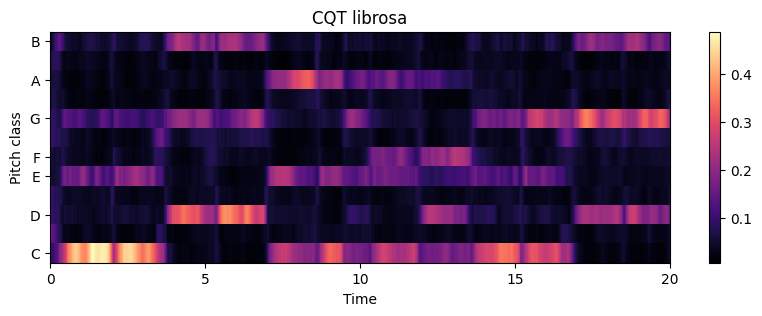

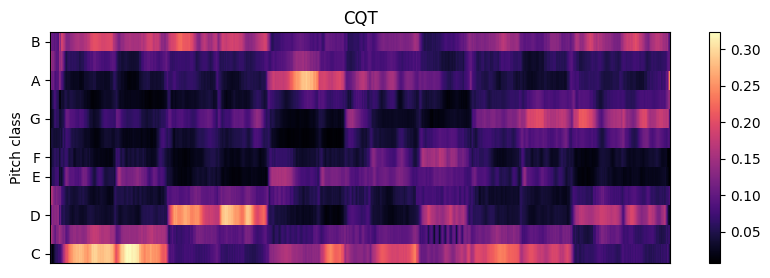

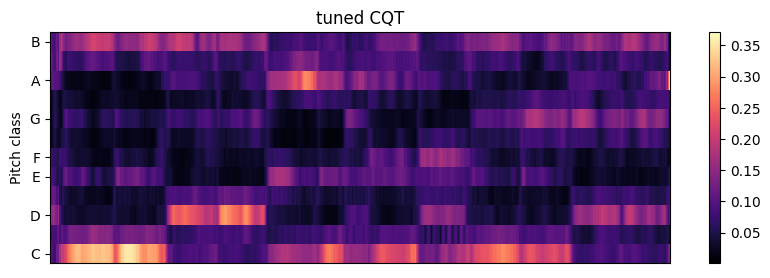

In [19]:

# Plot CQT spectrograms
import matplotlib.pyplot as plt
import numpy as np

# Initialize the chromagram with zeros
cqt_tuned = np.abs(cqt_tuned)
cqt = np.abs(cqt)
chromagram = np.zeros((cqt.shape[0],12))
chromagram_tuned = np.zeros((cqt_tuned.shape[0],12))

for t in range(cqt.shape[0]):
    for halftone in range(12):
        chromagram_tuned[t,halftone] = np.sum([cqt_tuned[t,halftone + (12 * octave)] for octave in range(7)])
        chromagram[t,halftone] = np.sum([cqt[t,halftone + (12 * octave)] for octave in range(7)])
# normalize
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)
max_val = np.sum(chroma_cq, axis=0)
chroma_cq = chroma_cq / (np.expand_dims(max_val, axis=0)+np.finfo(float).eps)

chroma = np.roll(chromagram,-3,axis=1)
max_val = np.sum(chroma, axis=1)
chroma = chroma / (np.expand_dims(max_val, axis=1)+np.finfo(float).eps)

chroma_tuned = np.roll(chromagram_tuned,-3,axis=1)
max_val = np.sum(chroma_tuned, axis=1)
chroma_tuned = chroma_tuned / (np.expand_dims(max_val, axis=1)+np.finfo(float).eps)

plt.figure(figsize=(10, 3))
plt.title("CQT librosa")
librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.figure(figsize=(10, 3))
plt.title("CQT")
librosa.display.specshow(chroma.T, y_axis='chroma')
plt.colorbar()
plt.figure(figsize=(10, 3))
plt.title("tuned CQT")
librosa.display.specshow(chroma_tuned.T, y_axis='chroma')
plt.colorbar()